# Requirements

In [1]:
# import libraries
! pip install unidecode
import unidecode
from bs4 import BeautifulSoup
import numpy as np
import pickle as pk
import warnings
warnings.simplefilter("ignore")
import random
import copy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import re
from gensim.models import KeyedVectors
# import nltk
from nltk import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
# download nltk resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

     |████████████████████████████████| 235 kB 7.2 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# download google news word vectors and unzip it
! wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz 
! gunzip GoogleNews-vectors-negative300.bin
# load word2vec model
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

--2021-10-10 06:15:38--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.12.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.12.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  41.2MB/s    in 40s     

2021-10-10 06:16:19 (38.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



# PART A

## In this part i define preprocesing class and some other required functions

In [2]:
# define class of preprocessing . three methods of this class do 3 diffrent level of preprocessing
class Preprocessing:
    
    def __init__(self,level):
        self.level = level
        
    def level_one_process(self,sent):
        return word_tokenize(sent)
    
    def level_two_process(self,sent):
        # delete numbers
        sent = re.sub("\d+", "", sent)
        # to lowercase
        sent = sent.lower()
        # tokenization and deleting punctuation marks
        tokenizer = RegexpTokenizer(r'\w+')
        return tokenizer.tokenize(sent)
        
    def level_three_process(self,sent):
        # remove html
        sent = self.remove_html_tags(sent)
        # convert accented
        sent = self.remove_accented_chars(sent)
        # apply level 2 processing first
        words = self.level_two_process(sent)
        # find and delete stop words
        stop_words = stopwords.words('english')
        new_words = [w for w in words if not w in stop_words]
        # lemmatization
        lemmatizer = WordNetLemmatizer()
        new_words = list(map(lemmatizer.lemmatize,new_words))
        return new_words
        
    def preprocess_sentence(self,sent):
        if self.level == 1:
            processed_sent = self.level_one_process(sent)
        elif self.level == 2:
            processed_sent = self.level_two_process(sent)
        elif self.level == 3:
            processed_sent = self.level_three_process(sent)
            
        return processed_sent

    def remove_html_tags(self,sent):
      soup = BeautifulSoup(sent, "html.parser")
      stripped_sent = soup.get_text(separator=" ")
      return stripped_sent

    def remove_accented_chars(self,sent):
      return unidecode.unidecode(sent)

In [9]:
# download dtaset from drive
! gdown --id 1-1qV9uGkvK-RRIF35e5sxnIFQArI1mA8
# read dataset
dataset = pd.read_csv('dataset.csv')
# put all comments in all_text and all labels in all_label
all_text = list(dataset['comment'].values)
all_label = list(dataset['sentiment'].values)
# preprocess text with level-3 preprocessing and add all text to bew_text array
new_text = []
p = Preprocessing(level=3)
for text in all_text:
  current_text = []
  processed_text = p.preprocess_sentence(text)
  for word in processed_text:
    current_text.append(word)
  new_text.append(current_text)


# turn text to vectors using loaded word2vec
vectorized_text = []
for comment in new_text:
  temp = []
  for word in comment:
    try:
      temp.append(word2vec_model.wv[word])
    except:
      pass

  vectorized_text.append(np.average(temp,axis=0))
# turn vectorized list to numpy array
del new_text
del word2vec_model
vectorized_text = np.array(vectorized_text)

Downloading...
From: https://drive.google.com/uc?id=1-1qV9uGkvK-RRIF35e5sxnIFQArI1mA8
To: /content/dataset.csv
100% 59.7M/59.7M [00:00<00:00, 142MB/s] 


In [10]:
# a function to produce results
def analysis(labels,predictions):
    print("Report Classification\n",classification_report(labels,predictions,target_names=["positive","negative"]))
    print("Matrix Confusion\n",confusion_matrix(labels,predictions))
    print("Accuracy\n",accuracy_score(labels,predictions))

# a function to get laster layer activations of data X and classifier
def get_last_layer(classifier, X):
        hidden_sizes = classifier.hidden_layer_sizes
        if not hasattr(hidden_sizes, "__iter__"):
            hidden_sizes = [hidden_sizes]
        hidden_sizes = list(hidden_sizes)
        layer_units = [X.shape[1]] + hidden_sizes + [classifier.n_outputs_]
        activations = [X]
        for i in range(classifier.n_layers_ - 1):
            activations.append(np.empty((X.shape[0],layer_units[i + 1])))
        classifier._forward_pass(activations)
        return activations[-2]

# load best mlp model from first phase of project
mlp_best = pk.load(open("best.pkl","rb"))
# get last layer vectors
last_layer_data = get_last_layer(mlp_best,vectorized_text)

# a class to generate bag-of-words vectors for words
class BagOfWords:
    def __init__(self,min_freq=None,vocab=None):
        if min_freq is None:
          self.min_freq = 1
        else:
          self.min_freq = min_freq
        self.vocab = vocab
    
    def make_vactors(self,text):
        CV = CountVectorizer(min_df=self.min_freq,vocabulary=self.vocab)
        bow = CV.fit_transform(text)
        return CV.vocabulary_, bow


# make bow objects of 3 levels of text
# apply level-3 preprocessing on text
level_3_processed_text = []
p = Preprocessing(level=3)
for text in all_text:
    level_3_processed_text.append(' '.join(p.preprocess_sentence(text)))
bow_obj = BagOfWords(min_freq=20)
vocab, bow_level_3_text = bow_obj.make_vactors(level_3_processed_text)

# PART B

## In this part in order to visulize 45,000 comment dataset i use the last layer features from the neural network of Notebook 1. Kmeans and GMM and Minibatch-Kmeans using different number of clusters have been applied to features and then brought to 2 dimension using PCA which you can observe

In [ ]:
# this function gets data and their labels and plot clusters
def plot_clusters(data,labels):
  max_label = np.max(labels)
  plt.figure(figsize=(10,10))
  for label in np.arange(max_label + 1):
    temp = []
    for i, label_ in enumerate(labels):
      if label == label_:
        temp.append(data[i])
    temp = np.array(temp)
    plt.scatter(temp[:,0],temp[:,1],s=4)

# apply PCA and reduce data dimensions to 2 dimensions
def pca_2(X):
  pca = PCA(n_components=2)
  return pca.fit_transform(X)

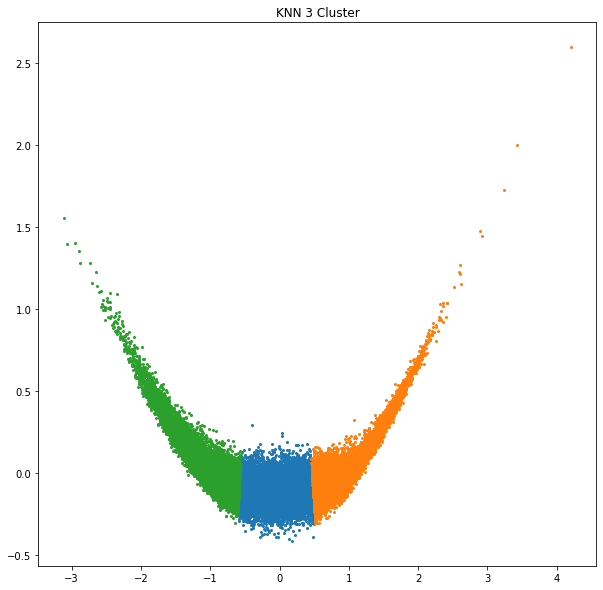

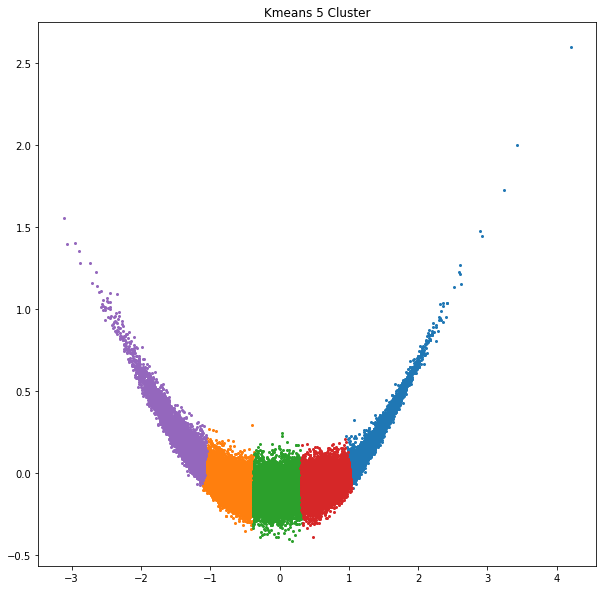

In [ ]:
# Kmeans
num_cluster = 3
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit_transform(last_layer_data)
last_layer_data_ = pca_2(last_layer_data)
plot_clusters(last_layer_data_,kmeans.labels_)
plt.title(f'KNN {num_cluster} Cluster')

num_cluster = 5
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit_transform(last_layer_data)
last_layer_data_ = pca_2(last_layer_data)
plot_clusters(last_layer_data_,kmeans.labels_)
plt.title(f'Kmeans {num_cluster} Cluster')

plt.show()

Text(0.5, 1.0, 'GMM 5 Mixture')

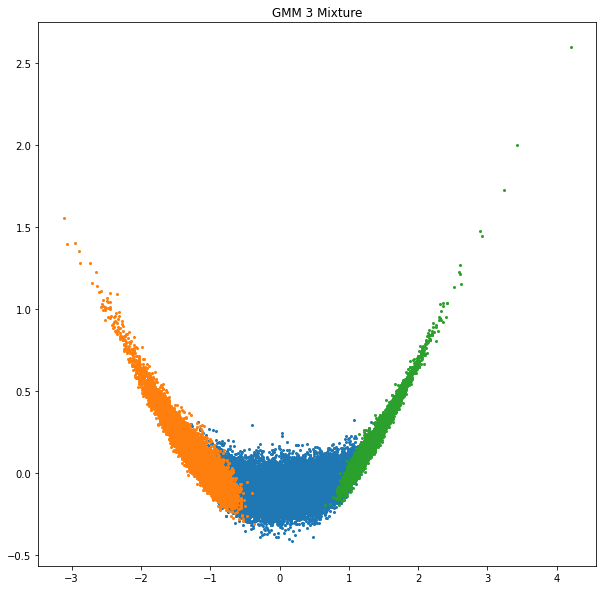

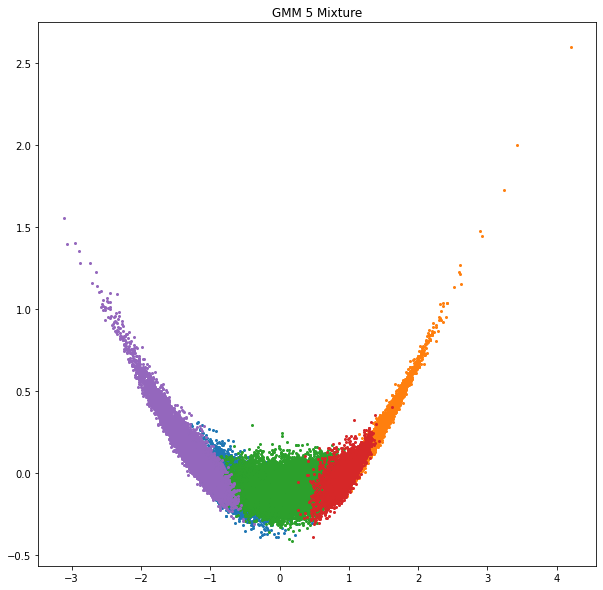

In [ ]:
# GMM
num_mixture = 3
gmm = GaussianMixture(n_components=num_mixture)
labels = gmm.fit_predict(last_layer_data)
last_layer_data_ = pca_2(last_layer_data)
plot_clusters(last_layer_data_,labels)
plt.title(f'GMM {num_mixture} Mixture')

num_mixture = 5
gmm = GaussianMixture(n_components=num_mixture)
labels = gmm.fit_predict(last_layer_data)
last_layer_data_ = pca_2(last_layer_data)
plot_clusters(last_layer_data_,labels)
plt.title(f'GMM {num_mixture} Mixture')

Text(0.5, 1.0, 'MiniBatch Kmeans 5 Cluster')

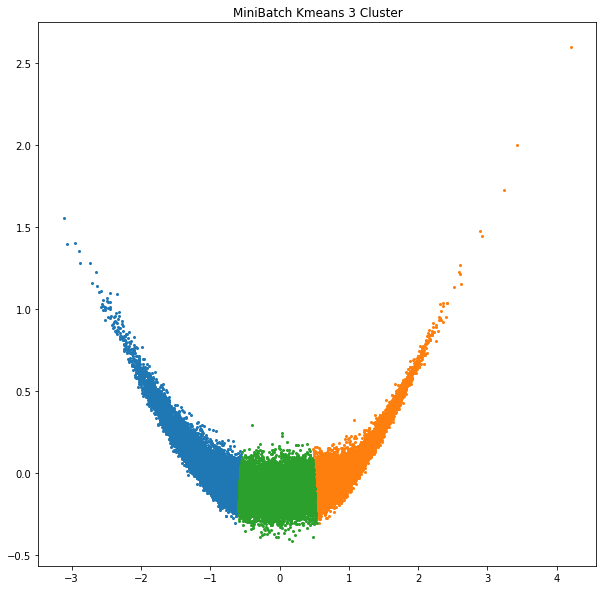

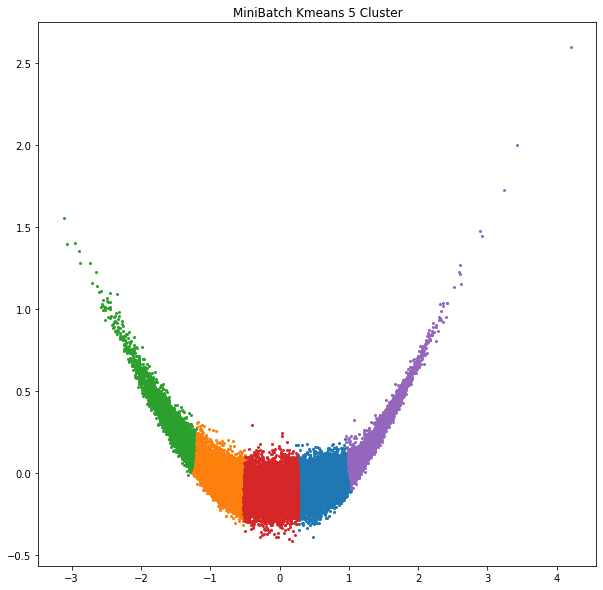

In [ ]:
# Mini-batch Kmeans
num_cluster = 3
mbkmeans = MiniBatchKMeans(n_clusters=num_cluster)
mbkmeans.fit(last_layer_data)
last_layer_data_ = pca_2(last_layer_data)
plot_clusters(last_layer_data_,mbkmeans.labels_)
plt.title(f'MiniBatch Kmeans {num_cluster} Cluster')

num_cluster = 5
mbkmeans = MiniBatchKMeans(n_clusters=num_cluster)
mbkmeans.fit(last_layer_data)
last_layer_data_ = pca_2(last_layer_data)
plot_clusters(last_layer_data_,mbkmeans.labels_)
plt.title(f'MiniBatch Kmeans {num_cluster} Cluster')

# PART C

## In this part some measures have been applied to previous algorithms using 2 clusters to measure their performance. here purity score and rand-index score measures have been applied

In [ ]:
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

num_cluster = 2
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit_transform(last_layer_data)
print(f'purity of kmeans with 2 clusters is {purity_score(all_label,kmeans.labels_)}')
print(f'rand-index of kmeans with 2 clusters is {adjusted_rand_score(all_label,kmeans.labels_)}\n')

num_mixture = 2
gmm = GaussianMixture(n_components=num_mixture)
labels = gmm.fit_predict(last_layer_data)
print(f'purity of GMM with 2 clusters is {purity_score(all_label,labels)}')
print(f'rand-index of GMM with 2 clusters is {adjusted_rand_score(all_label,labels)}\n')

num_cluster = 2
mnbkmeans = MiniBatchKMeans(n_clusters=num_cluster)
mnbkmeans.fit_transform(last_layer_data)
print(f'purity of minibatch-kmeans with 2 clusters is {purity_score(all_label,mnbkmeans.labels_)}')
print(f'rand-index of minibatch-kmeans with 2 clusters is {adjusted_rand_score(all_label,mnbkmeans.labels_)}')

purity of kmeans with 2 clusters is 0.8906444444444445
rand-index of kmeans with 2 clusters is 0.6104036700783679

purity of GMM with 2 clusters is 0.7104666666666667
rand-index of GMM with 2 clusters is 0.1771723449699423

purity of minibatch-kmeans with 2 clusters is 0.8911333333333333
rand-index of minibatch-kmeans with 2 clusters is 0.6119325189795429


# PARD D

## In this part i appied kmeans using 3 clusters and randomly sampled 10 commnet from each cluster to discern their discrepancy.
## Cluster 1: comments are mostly positive about movies
## Cluster 2: comments are mostly gentle and medicore about movies
## Cluster 3: comments are mostly very negative about movies

In [ ]:
# in this section im gonna print 10 samples of each cluster to analyze the problem based on them
num_cluster = 3
max_sample = 10
kmeans = KMeans(n_clusters=num_cluster)
kmeans.fit_transform(last_layer_data)
clusters = []

for current_cluster in range(num_cluster):
  temp = []
  for i, label in enumerate(kmeans.labels_):
    if label == current_cluster:
      if random.uniform(0,1) < .2:
        temp.append(all_text[i])
      if len(temp) == max_sample:
        break

  clusters.append(temp)

for i, cluster in enumerate(clusters):
  print(f'########################## CLUSTER {i + 1} ##########################')
  for text in cluster:
    print(text)
    print('----------------------------------------------------------------')


########################## CLUSTER 1 ##########################
Audiences today will probably watch a film like Ossessione and not really consider how unprecedented it was during the time when it came out. The structure of the film really divorces from sap-happy Hollywood conventionsas well as other major theatrical elements. It relies more upon depicting reality in a very grim and sober light. Films of this naturethe neo-realist filmswere made to reflect the darkness felt during post-World War II times. Ossessione tackles some fairly provocative issues that were probably unseen on screen prior to the war, including: adultery, conspiracy, murder, pregnancy, etc. Aside from the one crane shot and certain musical swelling moments, the film aesthetic is very raw and gritty: shot on-location, uses natural lighting and most likely non-popular actors. All of these elements helped convey the issues explored in the film, yielding the following theme: Negative karmic repercussions will haunt

# PART E

## here i apply a neural network on 500 comment dataset and finetune hyperparameters using validation

In [11]:
# download 500 comments dataset
! gdown --id 1-8BEiatoAWaxqtf-ZrbqvuOlnSna1iOd
new_dataset = pd.read_csv('dataset.csv')
new_all_text = list(new_dataset['comment'].values)
new_all_label = list(new_dataset['sentiment'].values)

# make bow objects of 3 levels of text
# apply level-3 preprocessing on text
new_level_3_processed_text = []
p = Preprocessing(level=3)
for text in new_all_text:
    new_level_3_processed_text.append(' '.join(p.preprocess_sentence(text)))

# make new bow object for new dataset using main data(450000 data) vocabulary to use in the second part of problem
new_bow_obj = BagOfWords(vocab=vocab)
_, new_bow_level_3_text = new_bow_obj.make_vactors(new_level_3_processed_text)
new_all_label = list(map(lambda x:'positive' if x == 1 else 'negative',new_all_label))
new_x_train, new_x_val, new_y_train, new_y_val = train_test_split(new_bow_level_3_text,new_all_label,test_size=.2)
# make new bow object for new dataset without using any vocabulary . this bow object is used in the first part to train mlp model
bow_obj = BagOfWords(min_freq=20)
_, bow_level_3_text = bow_obj.make_vactors(new_level_3_processed_text)
x_train, x_val, y_train, y_val = train_test_split(bow_level_3_text,new_all_label,test_size=.2)

Downloading...
From: https://drive.google.com/uc?id=1-8BEiatoAWaxqtf-ZrbqvuOlnSna1iOd
To: /content/dataset.csv
100% 211k/211k [00:00<00:00, 63.4MB/s]


In [ ]:
hidden_size_1 = 100
hidden_size_2 = 100
best_score = 0
alphas = np.linspace(1e-6,1e-2,3)
lrs = np.linspace(1e-5,1e-2,3)
best_model = None

for lr in lrs:
  for alpha in alphas:
    mlp_clf = MLPClassifier(activation='relu',hidden_layer_sizes=(hidden_size_1,hidden_size_2),solver='adam',learning_rate_init=lr,alpha=alpha)
    mlp_clf.fit(x_train,y_train)
    y_val_pred = mlp_clf.predict(x_val)
    score = accuracy_score(y_val,y_val_pred)
    if score > best_score:
        best_score = score
        best_lr_alpha = [lr,alpha]
        best_model = mlp_clf

print(f'best lr, alpha is {best_lr_alpha[0]}, {best_lr_alpha[1]}')
print('start training best model on best lr and alpha\n\n')

y_val_pred = best_model.predict(x_val)
analysis(y_val,y_val_pred)

best lr, alpha is 0.005005, 0.005000500000000001
start training best model on best lr and alpha


Report Classification
               precision    recall  f1-score   support

    positive       0.76      0.75      0.75        51
    negative       0.74      0.76      0.75        49

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100

Matrix Confusion
 [[38 13]
 [12 37]]
Accuracy
 0.75


# PART F

## In this section i apply transfer learning fo 500 commnet dataset on the best model obtained from the first notebook using 45,000 datset. the best model there is Logistic regression which is obvious in Notebook 1 here the best model is obtained using validation on l2-regularization coefficient and learning rate

In [ ]:
best_model_lr = pk.load(open("LR.pkl","rb"))
best_score = 0
Cs = np.linspace(.01,1,9)
best_model_fine_tune = None

for C in Cs:
  best_model_lr_copy = copy.deepcopy(best_model_lr)
  params = {'C':C,'verbose':False,'warm_start':True,'max_iter':10000,'tol':1e-5}
  best_model_lr_copy.set_params(**params)
  best_model_lr_copy.fit(new_x_train,new_y_train)
  new_y_val_pred = best_model_lr_copy.predict(new_x_val)
  score = accuracy_score(new_y_val,new_y_val_pred)
  if score > best_score:
      best_score = score
      best_C = C
      best_model_fine_tune = best_model_lr_copy

new_y_val_pred = best_model_fine_tune.predict(new_x_val)
analysis(new_y_val,new_y_val_pred)

Report Classification
               precision    recall  f1-score   support

    positive       0.78      0.76      0.77        46
    negative       0.80      0.81      0.81        54

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

Matrix Confusion
 [[35 11]
 [10 44]]
Accuracy
 0.79


## Conclusion of E & F => transfer learning improved 4% accuracy on smaller dataset